In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import InputLayer, Activation, Dense, Dropout, Embedding, LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the sampling rate of the ECG signals
sampling_rate = 100
# Define the path to the dataset folder
path = 'ptb-xl-dataset-1.0.3/'

# Load and convert the annotation data from a CSV file
# Index the data by the ECG ID
Y = pd.read_csv(path +'ptbxl_database.csv', index_col='ecg_id')

# Convert the string-encoded SCP codes into actual Python lists
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

I performed a wavelet transformation, which is a mathematical technique that decomposes a signal into different frequency sub-bands, enabling the analysis of both its frequency and time-domain characteristics.

By performing wavelet transformation on ECG signals, the signal can be decomposed into different frequency sub-bands, allowing the identification and removal of noise components from specific frequency ranges. Additionally, this decomposition can be used for feature extraction by analyzing each sub-band separately, which can be particularly useful for identifying important diagnostic features in ECG signals.

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Define wavelet family and level of decomposition
wavelet = 'db4'
level = 3

# Perform wavelet transformation on each signal
X_wt = []
for signal in X:
    # Apply wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Extract approximation coefficients
    cA4, cD3, cD2, cD1 = coeffs
    # Concatenate approximation coefficients into a single signal ()
    approx = pywt.waverec([cA4, None, None, None, None], wavelet)
    # Append approximation coefficients to list
    X_wt.append(approx)
    
# Convert list to numpy array
X_wt = np.array(X_wt)

C:\Users\linus\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler
# Normalize the wavelet-transformed signals using StandardScaler
scaler = StandardScaler()
scaler.fit(X_wt.reshape(-1, X_wt.shape[-1]))
X_wt = scaler .transform(X_wt.reshape(-1, X_wt.shape[-1])).reshape(X_wt.shape)

In [ ]:
# Save preprocessed data as a NumPy array
np.save('X_wt_data.npy', X_wt)

In [ ]:
X_wt = np.load('/content/drive/MyDrive/ECG/X_wt_data.npy')
X_wt

array([[[-0.39028535, -0.3543606 , -0.31502456, ..., -0.21448954,
         -0.20607216, -0.19709161],
        [-0.37363438, -0.34108718, -0.3052302 , ..., -0.20403629,
         -0.19508596, -0.18568357],
        [-0.3390358 , -0.30950702, -0.2773801 , ..., -0.18953036,
         -0.18137182, -0.17277794],
        ...,
        [ 0.00875342, -0.00997903, -0.02587644, ..., -0.15969058,
         -0.15713354, -0.15347665],
        [ 0.11527966,  0.09726981,  0.08006315, ..., -0.1272084 ,
         -0.13224691, -0.13569053],
        [-0.08192776, -0.07113932, -0.05871366, ..., -0.25799546,
         -0.26408438, -0.26766926]],

       [[ 0.70665991,  0.64608336,  0.57367572, ...,  0.50699628,
          0.4951309 ,  0.48092089],
        [ 0.57107292,  0.52116137,  0.46115527, ...,  0.3812982 ,
          0.37157633,  0.36018823],
        [ 0.40012691,  0.36123452,  0.31441758, ...,  0.18516483,
          0.17824544,  0.17080466],
        ...,
        [-2.0593974 , -2.85348385, -3.55989578, ..., -

In [ ]:
print("X_wt: ", X_wt.shape, "Y: ", Y.shape)

X_wt:  (21799, 1000, 22) Y:  (21799, 27)


In [ ]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('/content/drive/MyDrive/ECG/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
agg_df

The aggregate_diagnostic method generates a diagnosis for each signal, which is then stored in a column called diagnostic_superclass.

In [ ]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [ ]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [ ]:
count_norm = 0
count_mi = 0
count_sttc = 0
count_cd = 0
count_hyp = 0
count = 0

for diagnosis in Y['diagnostic_superclass']:
    count_norm += diagnosis.count('NORM')
    count_mi += diagnosis.count('MI')
    count_sttc += diagnosis.count('STTC')
    count_cd += diagnosis.count('CD')
    count_hyp += diagnosis.count('HYP')
    if not diagnosis:
        count += 1
    
print('Number of [NORM]:', count_norm)
print('Number of [MI]:', count_mi)
print('Number of [STTC]:', count_sttc)
print('Number of [CD]:', count_cd)
print('Number of [HYP]:', count_hyp)
print('Number of []:', count)

Number of [NORM]: 9514
Number of [MI]: 5469
Number of [STTC]: 5235
Number of [CD]: 4898
Number of [HYP]: 2649
Number of []: 411


The dataset is characterized by an imbalanced distribution of diagnoses, with several rows lacking a diagnosis label.

In [ ]:
empty_diagnosis = Y[Y['diagnostic_superclass'].apply(len) == 0]
empty_diagnosis

Deleting these rows would result in the loss of valuable data for training the neural network. As I am not a medical expert and cannot identify the diagnoses for these undiagnosed cases, I will label them as 'Unknown' to ensure that the data is retained for further analysis.

Creating a new diagnostic superclass for rows with empty diagnosis is a common practice in medical datasets where missing data is a common issue. The approach allows me to retain the information from these rows while still being able to use them in my analysis. By assigning an 'unknown' or 'unclassified' diagnostic superclass, I am explicitly acknowledging that the diagnosis for these rows is not known, which can be important for interpretation and analysis.

In [ ]:
# Adds a new column with 'unknown' diagnostic superclass for rows with empty diagnosis
Y['UNK'] = Y ['diagnostic_superclass'].apply(lambda x: 1 if len(x) == 0 else 0)

Since a signal can have more than one diagnosis, I will use multi-label classification. Therefore, I will create columns for each diagnosis, containing either a 0 or 1 to indicate whether the ECG signal has the diagnosis.

In [ ]:
Y['NORM'] = Y['diagnostic_superclass'].apply(lambda x: 1 if 'NORM' in x else 0)
Y['MI'] = Y['diagnostic_superclass'].apply(lambda x:1 if 'MI' in x else 0)
Y['STTC'] = Y['diagnostic_superclass'].apply(lambda x:1 if 'STTC' in x else 0)
Y['CD'] = Y['diagnostic_superclass'].apply(lambda x:1 if 'CD' in x else 0)
Y['HYP'] = Y['diagnostic_superclass'].apply(lambda x:1 if 'HYP' in x else 0)

In [ ]:
binary_labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']
Y_binary = Y[binary_labels]
Y_binary

,NORM,MI,STTC,CD,HYP,UNK
ecg_id,,,,,,
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,1,0,0,0,0,0
...,...,...,...,...,...,...
21833,0,0,1,0,0,0
21834,1,0,0,0,0,0
21835,0,0,1,0,0,0


Z is a vector containing metadata information for each ECG signal.

In [ ]:
# Checking for null values in Y
Y.isnull().sum()

patient_id                          0
age                                 0
sex                                 0
height                          14825
weight                          12378
nurse                            1473
site                               17
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8468
infarction_stadium1             16187
infarction_stadium2             21696
validated_by                     9378
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20201
static_noise                    18539
burst_noise                     21186
electrodes_problems             21769
extra_beats                     19850
pacemaker                       21508
strat_fold                          0
filename_lr                         0
filename_hr 

Alot of the columns have null values but age, sex and device doesnt. Age and sex can be useful when analyzing ECG signals because they are associated with changes in the cardiovascular system. Devices can also be useful, as slight differences between devices can result in different output, which can provide additional information or insights. I included pacemaker as I noticed that many of the ECG signals with an unknown diagnosis had a pacemaker indicated in their metadata.

In [4]:
# Define relevant column names
relevant_columns = ['age', 'sex', 'device', 'pacemaker']

# Create new DataFrame with relevant columns
Z = Y.loc[:, relevant_columns]
Z

,age,sex,device,pacemaker
ecg_id,,,,
1,56.0,1,CS-12 E,NaN
2,19.0,0,CS-12 E,NaN
3,37.0,1,CS-12 E,NaN
4,24.0,0,CS-12 E,NaN
5,19.0,1,CS-12 E,NaN
...,...,...,...,...
21833,67.0,1,AT-60 3,NaN
21834,300.0,0,AT-60 3,NaN
21835,59.0,1,AT-60 3,NaN


In [5]:
Z['pacemaker'].unique()

array([nan, 'ja, pacemaker', 'PACE????, nan', 'ja, nan', '?, nan'],
      dtype=object)

I will replace all the NaN values with 0 since it can be assumed that if the pacemaker information is not included, the patient did not have one. Additionally, I will replace the values 'PACE????, nan' and '?, nan' with 0, while the remaining values will be replaced with 1.

In [14]:
# Replace missing values with zeros
Z['pacemaker'].fillna(value=0, inplace=True)

# Replace '?, nan' and 'ja, nan' with zeros
Z['pacemaker'].replace('PACE????, nan', 0, inplace=True)
Z['pacemaker'].replace('?, nan', 0, inplace=True)

# Replace 'ja, pacemaker' and 'ja, nan' with 1
Z['pacemaker'].replace('ja, pacemaker', 1, inplace=True)
Z['pacemaker'].replace('ja, nan', 1, inplace=True)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the ecg_id column using the LabelEncoder
Z['device'] = le.fit_transform(Z['device'])

There seems to be an outlier where the age is 300 which is impossible. Therefore, I checked if there are more outliers with unrealistic ages.

In [16]:
under_1 = Z[Z["age"]  < 1]
under_1

,age,sex,device,pacemaker
ecg_id,,,,


In [17]:
over_100 = Z[Z["age"] > 100]
over_100

,age,sex,device,pacemaker
ecg_id,,,,
108,300.0,1,9,0
255,300.0,1,2,0
256,300.0,1,4,0
279,300.0,0,4,0
282,300.0,0,4,0
...,...,...,...,...
20865,300.0,1,7,0
20878,300.0,1,7,0
21121,300.0,1,8,0


In [18]:
age_300 = Z[Z["age"] == 300]
age_300

,age,sex,device,pacemaker
ecg_id,,,,
108,300.0,1,9,0
255,300.0,1,2,0
256,300.0,1,4,0
279,300.0,0,4,0
282,300.0,0,4,0
...,...,...,...,...
20865,300.0,1,7,0
20878,300.0,1,7,0
21121,300.0,1,8,0


All of the age outliers share the same value, 300. Assuming it was a typing error, I corrected it by replacing all instances of 300 with 30.

In [19]:
Z.loc[Z["age"] == 300, "age"] = 30
age_300 = Z[Z["age"] == 300]
age_300

,age,sex,device,pacemaker
ecg_id,,,,


In [ ]:
# Split data into train and test

# Test fold
test_fold = 10
# Validation fold
valid_fold = 9

# Train
X_wt_train = X_wt[np.logical_and(Y.strat_fold != test_fold, Y.strat_fold != valid_fold)]
X_train = X_wt[np.logical_and(Y.strat_fold != test_fold, Y.strat_fold != valid_fold)]

y_train = Y_binary[np.logical_and(Y.strat_fold != test_fold, Y.strat_fold != valid_fold)]
z_train = Z[np.logical_and(Y.strat_fold != test_fold, Y.strat_fold != valid_fold)]
# Validation
X_wt_valid = X_wt[Y.strat_fold == valid_fold]
X_valid = X[Y.strat_fold == valid_fold]

y_valid = Y_binary[Y.strat_fold == valid_fold]
z_valid = Z[Y.strat_fold == valid_fold]
# Test
X_wt_test = X_wt[Y.strat_fold == test_fold]
X_test = X_wt[Y.strat_fold == test_fold]

y_test = Y_binary[Y.strat_fold == test_fold]
z_test = Z[Y.strat_fold == test_fold]

#X_train.shape, y_train.shape, z_train.shape, X_test.shape, y_test.shape, z_test.shape, X_valid.shape, y_valid.shape, z_valid.shape

In [ ]:
X_train = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/X_train.npy')
y_train = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/y_train.npy')
z_train = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/z_train.npy')

X_valid = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/X_valid.npy')
y_valid = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/y_valid.npy')
z_valid = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/z_valid.npy')

X_test = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/X_test.npy')
y_test = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/y_test.npy')
z_test = np.load('/content/drive/MyDrive/ECG/Train_Test_Valid/z_test.npy')

In [ ]:
y_train

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

# Traning

During my training, I plan to experiment with architectures using three vectors [X,Y,Z] with two branches, as well as a model with a single branch that uses the vectors [X,Y]. I intend to evaluate both the wavelet transformed ECG signals and the raw ECG signals with these models.

I trained a model using wavelet transformed ECG signals with a two-branch architecture. One branch toke patient metadata as input, while the other branch toke ECG signals as input. The outputs of these branches is combined to predict the diagnosis.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X (InputLayer)           [(None, 1000, 22)]   0           []                               
                                                                                                  
 X_conv_1 (Conv1D)              (None, 1000, 32)     3552        ['input_X[0][0]']                
                                                                                                  
 X_bn_1 (BatchNormalization)    (None, 1000, 32)     128         ['X_conv_1[0][0]']               
                                                                                                  
 X_act_1 (Activation)           (None, 1000, 32)     0           ['X_bn_1[0][0]']                 
                                                                                              

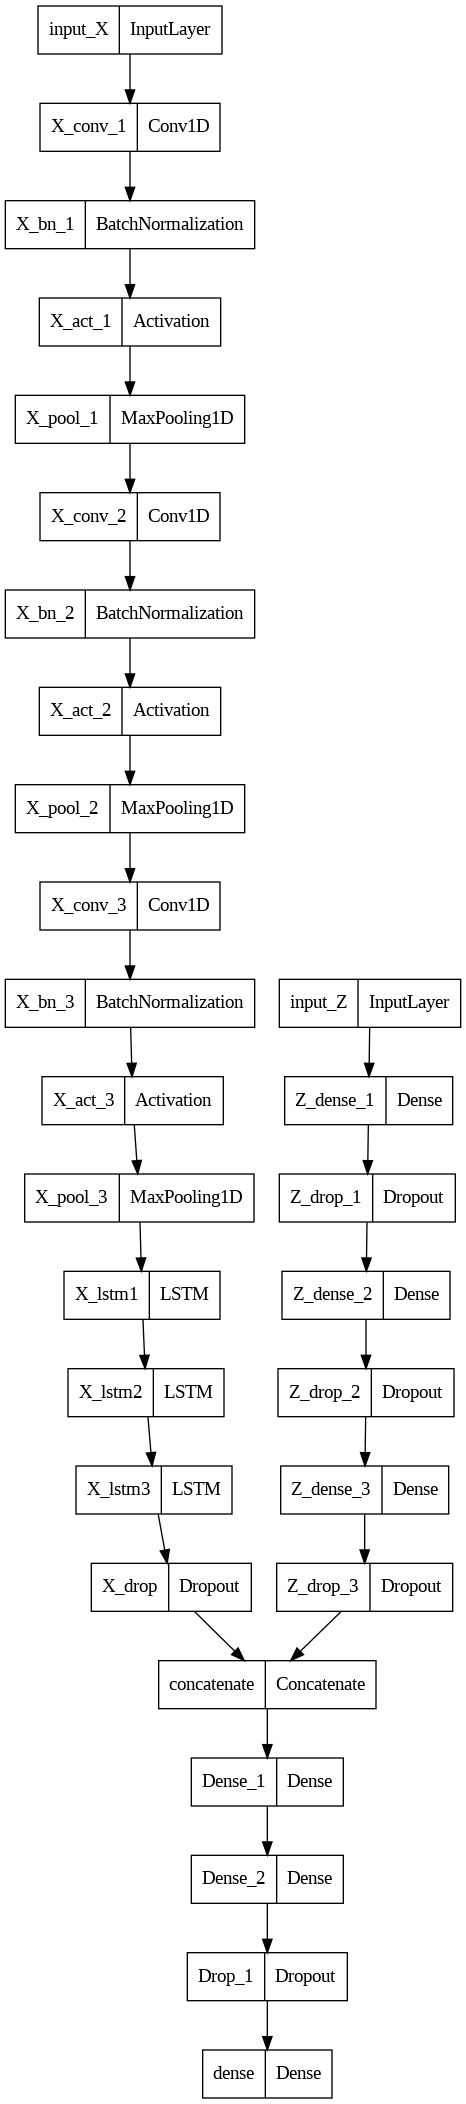

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, Dropout, concatenate
from tensorflow.keras.models import Model

# Input shapes
input_shape_X = X_wt_train.shape[1:]
input_shape_Z = z_train.shape[1:]

# Input layers
input_X = Input(shape=input_shape_X, name='input_X')
input_Z = Input(shape=input_shape_Z, name='input_Z')

X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', name='X_conv_1')(input_X)
X = BatchNormalization(name='X_bn_1')(X)
X = Activation('relu', name='X_act_1')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_1')(X)

X = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name='X_conv_2')(X)
X = BatchNormalization(name='X_bn_2')(X)
X = Activation('relu', name='X_act_2')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_2')(X)

X = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='X_conv_3')(X)
X = BatchNormalization(name='X_bn_3')(X)
X = Activation('relu', name='X_act_3')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_3')(X)

X = LSTM(units=64, activation='tanh', return_sequences=True, name='X_lstm1')(X)
X = LSTM(units=64, activation='tanh', return_sequences=True, name='X_lstm2')(X)
X = LSTM(units=32, return_sequences=False, name='X_lstm3')(X)
X = Dropout(rate=0.5, name='X_drop')(X)

Z = Dense(units=64, activation='relu', name='Z_dense_1')(input_Z)
Z = Dropout(0.3, name='Z_drop_1')(Z)
Z = Dense(units=32, activation='relu', name='Z_dense_2')(Z)
Z = Dropout(0.3, name='Z_drop_2')(Z)
Z = Dense(units=16, activation='relu', name='Z_dense_3')(Z)
Z = Dropout(0.3, name='Z_drop_3')(Z)


combined = concatenate([X, Z], name='concatenate')
combined = Dense(64, activation='relu', name='Dense_1')(combined)
combined = Dense(64, activation='relu', name='Dense_2')(combined)
combined = Dropout(0.5, name='Drop_1')(combined)

outputs = Dense(y_train.shape[1], activation='softmax')(combined)

model = Model(inputs=[input_X, input_Z], outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_accuracy', 'Precision', 'Recall'])
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.0001)

# Model traning
history = model.fit([X_wt_train, z_train], y_train, validation_data=([X_wt_valid, z_valid], y_valid), epochs=100, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/100
545/545 [==============================] - 43s 39ms/step - loss: 0.4253 - accuracy: 0.4856 - binary_accuracy: 0.8126 - precision: 0.7001 - recall: 0.2280 - val_loss: 0.3613 - val_accuracy: 0.5451 - val_binary_accuracy: 0.8269 - val_precision: 0.7996 - val_recall: 0.2628 - lr: 0.0010
Epoch 2/100
545/545 [==============================] - 17s 31ms/step - loss: 0.3709 - accuracy: 0.5613 - binary_accuracy: 0.8290 - precision: 0.7418 - recall: 0.3170 - val_loss: 0.3285 - val_accuracy: 0.5863 - val_binary_accuracy: 0.8472 - val_precision: 0.7384 - val_recall: 0.4509 - lr: 0.0010
Epoch 3/100
545/545 [==============================] - 18s 34ms/step - loss: 0.3404 - accuracy: 0.5952 - binary_accuracy: 0.8444 - precision: 0.7589 - recall: 0.4070 - val_loss: 0.3137 - val_accuracy: 0.6106 - val_binary_accuracy: 0.8574 - val_precision: 0.7631 - val_recall: 0.4906 - lr: 0.0010
Epoch 4/100
545/545 [==============================] - 17s 32ms/step - loss: 0.3246 - accuracy: 0.6220 - binary_

In [ ]:
# Evaluating the model on the test set
test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = model.evaluate([X_wt_test, z_test], y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test binary accuracy:', test_binary_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

F1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print('F1_score:', F1_score)

69/69 [==============================] - 2s 22ms/step - loss: 0.2569 - accuracy: 0.7152 - binary_accuracy: 0.8833 - precision: 0.8174 - recall: 0.5879
Test loss: 0.2568504214286804
Test accuracy: 0.7151956558227539
Test binary accuracy: 0.8833029866218567
Test precision: 0.8173785209655762
Test recall: 0.5879237055778503
F1_score: 0.6839186615221293


69/69 [==============================] - 2s 12ms/step


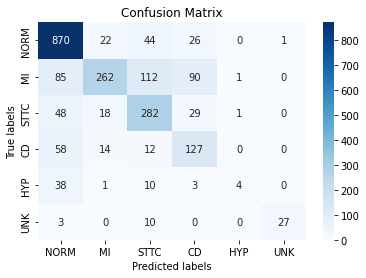

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_wt_test, z_test])
y_pred_arg = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_arg)

labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

This model was trained using wavelet-transformed ECG signals with a single sequential branch that included convoluted layers and LSTM layers.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 996, 64)           7104      
                                                                 
 batch_normalization (BatchN  (None, 996, 64)          256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 996, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 32)           6

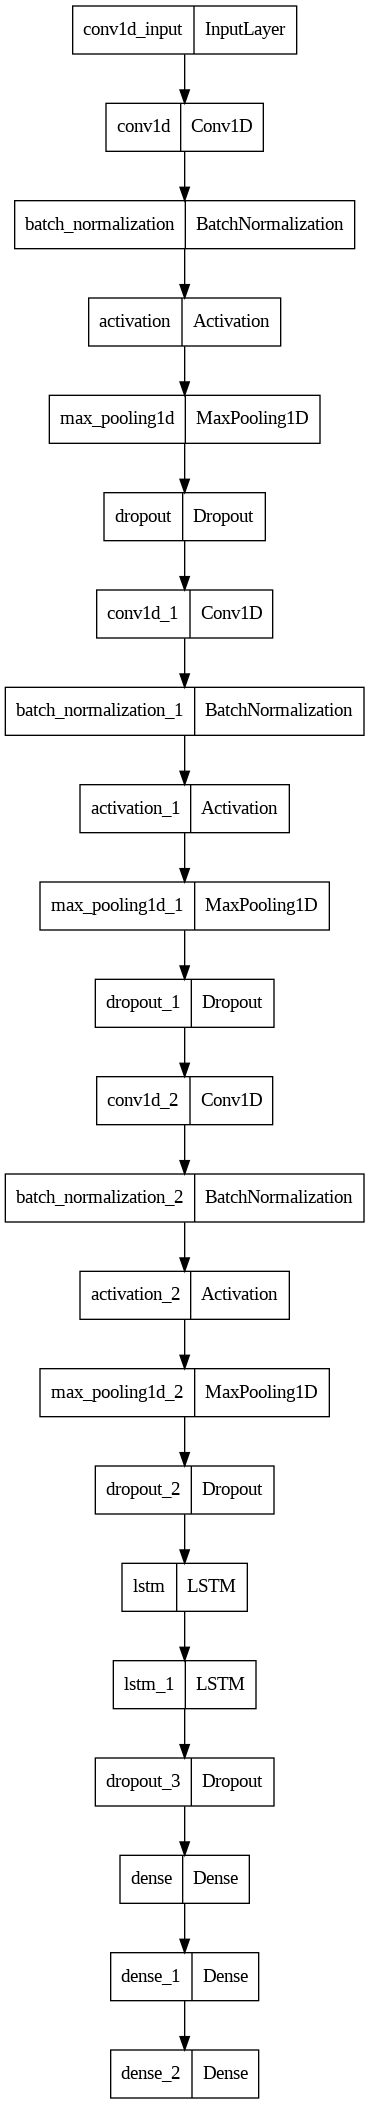

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, Dropout, concatenate, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers

sequence_length = X_wt_train.shape[1] # 1000
input_dim = X_wt_train.shape[2] # 12
num_classes = y_train.shape[1] # 6

model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv1D(32, 3, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv1D(16, 2, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(LSTM(32, input_shape=(sequence_length, input_dim), return_sequences=True))
model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))

model2.add(Dense(num_classes, activation='softmax'))

model2.summary()
tf.keras.utils.plot_model(model2)

In [ ]:
from tensorflow.keras.optimizers import Adam
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy', 'Precision', 'Recall'])

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.0001)

model2.fit(X_wt_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_wt_valid, y_valid)
                    ,callbacks=[early_stop, reduce_lr])

Epoch 1/100
545/545 [==============================] - 30s 24ms/step - loss: 0.4134 - accuracy: 0.5106 - binary_accuracy: 0.8157 - precision: 0.7256 - recall: 0.2327 - val_loss: 0.3669 - val_accuracy: 0.5506 - val_binary_accuracy: 0.8299 - val_precision: 0.7283 - val_recall: 0.3362 - lr: 0.0010
Epoch 2/100
545/545 [==============================] - 12s 22ms/step - loss: 0.3567 - accuracy: 0.5894 - binary_accuracy: 0.8405 - precision: 0.7306 - recall: 0.4117 - val_loss: 0.3485 - val_accuracy: 0.6024 - val_binary_accuracy: 0.8426 - val_precision: 0.7131 - val_recall: 0.4516 - lr: 0.0010
Epoch 3/100
545/545 [==============================] - 12s 21ms/step - loss: 0.3349 - accuracy: 0.6303 - binary_accuracy: 0.8529 - precision: 0.7528 - recall: 0.4727 - val_loss: 0.3305 - val_accuracy: 0.6276 - val_binary_accuracy: 0.8536 - val_precision: 0.7521 - val_recall: 0.4782 - lr: 0.0010
Epoch 4/100
545/545 [==============================] - 12s 21ms/step - loss: 0.3229 - accuracy: 0.6419 - binary_

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = model2.evaluate(X_wt_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test binary accuracy:', test_binary_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

F1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print('F1_score:', F1_score)

69/69 [==============================] - 1s 16ms/step - loss: 0.2706 - accuracy: 0.6943 - binary_accuracy: 0.8797 - precision: 0.8030 - recall: 0.5830
Test loss: 0.27057671546936035
Test accuracy: 0.6942675113677979
Test binary accuracy: 0.8797391653060913
Test precision: 0.8030155897140503
Test recall: 0.582980215549469
F1_score: 0.6755319169123649


69/69 [==============================] - 3s 14ms/step


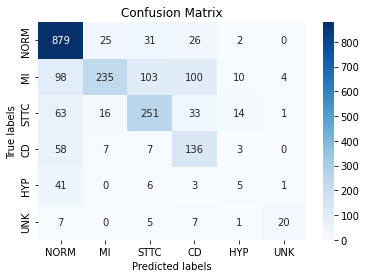

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model2.predict(X_wt_test)
y_pred_arg = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_arg)

labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

Training without wavelet-transformed ECG signals

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 X_conv_1 (Conv1D)              (None, 1000, 32)     1952        ['input_X[0][0]']                
                                                                                                  
 X_bn_1 (BatchNormalization)    (None, 1000, 32)     128         ['X_conv_1[0][0]']               
                                                                                                  
 X_act_1 (Activation)           (None, 1000, 32)     0           ['X_bn_1[0][0]']                 
                                                                                              

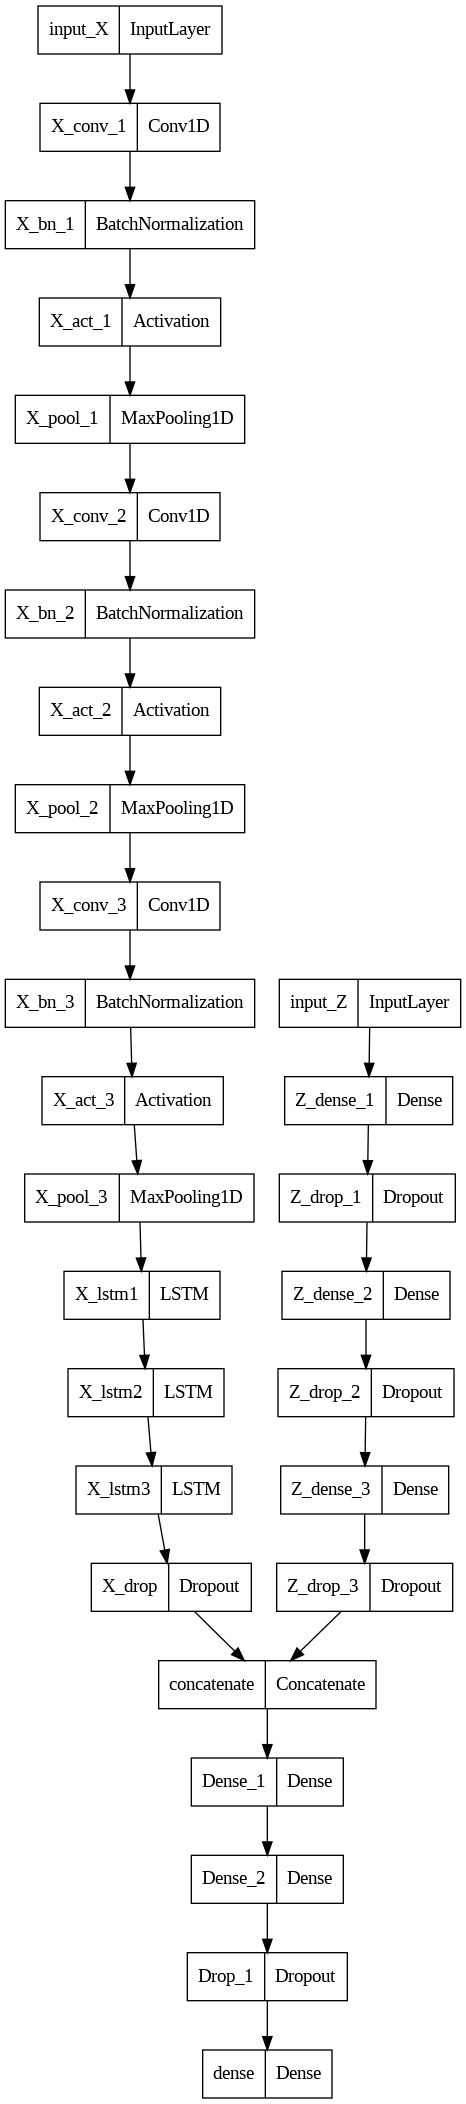

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, Dropout, concatenate
from tensorflow.keras.models import Model

# Input shapes
input_shape_X = X_train.shape[1:]
input_shape_Z = z_train.shape[1:]

# Input layers
input_X = Input(shape=input_shape_X, name='input_X')
input_Z = Input(shape=input_shape_Z, name='input_Z')

X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', name='X_conv_1')(input_X)
X = BatchNormalization(name='X_bn_1')(X)
X = Activation('relu', name='X_act_1')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_1')(X)

X = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name='X_conv_2')(X)
X = BatchNormalization(name='X_bn_2')(X)
X = Activation('relu', name='X_act_2')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_2')(X)

X = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='X_conv_3')(X)
X = BatchNormalization(name='X_bn_3')(X)
X = Activation('relu', name='X_act_3')(X)
X = MaxPooling1D(pool_size=2, name='X_pool_3')(X)

X = LSTM(units=64, activation='tanh', return_sequences=True, name='X_lstm1')(X)
X = LSTM(units=64, activation='tanh', return_sequences=True, name='X_lstm2')(X)
X = LSTM(units=32, return_sequences=False, name='X_lstm3')(X)
X = Dropout(rate=0.5, name='X_drop')(X)

Z = Dense(units=64, activation='relu', name='Z_dense_1')(input_Z)
Z = Dropout(0.3, name='Z_drop_1')(Z)
Z = Dense(units=32, activation='relu', name='Z_dense_2')(Z)
Z = Dropout(0.3, name='Z_drop_2')(Z)
Z = Dense(units=16, activation='relu', name='Z_dense_3')(Z)
Z = Dropout(0.3, name='Z_drop_3')(Z)

combined = concatenate([X, Z], name='concatenate')
combined = Dense(64, activation='relu', name='Dense_1')(combined)
combined = Dense(64, activation='relu', name='Dense_2')(combined)
combined = Dropout(0.5, name='Drop_1')(combined)

outputs = Dense(y_train.shape[1], activation='softmax')(combined)

model = Model(inputs=[input_X, input_Z], outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_accuracy', 'Precision', 'Recall'])
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.0001)

history = model.fit([X_train, z_train], y_train, validation_data=([X_valid, z_valid], y_valid), epochs=100, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/100
545/545 [==============================] - 37s 30ms/step - loss: 0.4208 - accuracy: 0.4962 - binary_accuracy: 0.8175 - precision: 0.7247 - recall: 0.2468 - val_loss: 0.3505 - val_accuracy: 0.5644 - val_binary_accuracy: 0.8278 - val_precision: 0.7152 - val_recall: 0.3344 - lr: 0.0010
Epoch 2/100
545/545 [==============================] - 13s 25ms/step - loss: 0.3565 - accuracy: 0.5855 - binary_accuracy: 0.8382 - precision: 0.7739 - recall: 0.3522 - val_loss: 0.3245 - val_accuracy: 0.6047 - val_binary_accuracy: 0.8536 - val_precision: 0.7567 - val_recall: 0.4725 - lr: 0.0010
Epoch 3/100
545/545 [==============================] - 13s 24ms/step - loss: 0.3318 - accuracy: 0.6188 - binary_accuracy: 0.8519 - precision: 0.7870 - recall: 0.4287 - val_loss: 0.3101 - val_accuracy: 0.6596 - val_binary_accuracy: 0.8644 - val_precision: 0.7850 - val_recall: 0.5108 - lr: 0.0010
Epoch 4/100
545/545 [==============================] - 13s 24ms/step - loss: 0.3161 - accuracy: 0.6559 - binary_

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = model.evaluate([X_test, z_test], y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test binary accuracy:', test_binary_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

69/69 [==============================] - 1s 18ms/step - loss: 0.2520 - accuracy: 0.7298 - binary_accuracy: 0.8845 - precision: 0.8176 - recall: 0.5950
Test loss: 0.2519596517086029
Test accuracy: 0.7297543287277222
Test binary accuracy: 0.884516179561615
Test precision: 0.8175643086433411
Test recall: 0.5949859023094177


In [ ]:
F1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print('F1_score:', F1_score)

F1_score: 0.6887390396494755


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict([X_test, z_test])
y_pred_arg = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_arg)

for i, label in enumerate(['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']):
    print(f'Confusion matrix for {label}:')
    print(cm[i])

69/69 [==============================] - 10s 102ms/step
Confusion matrix for NORM:
[886  26  28  21   1   1]
Confusion matrix for MI:
[ 82 255 103 110   0   0]
Confusion matrix for STTC:
[ 54  23 265  34   2   0]
Confusion matrix for CD:
[ 59   6  11 133   2   0]
Confusion matrix for HYP:
[39  1  5  3  8  0]
Confusion matrix for UNK:
[ 5  1  7  0  0 27]


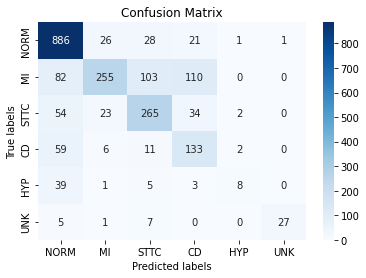

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class labels
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 996, 64)           3904      
                                                                 
 batch_normalization (BatchN  (None, 996, 64)          256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 996, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 32)           6

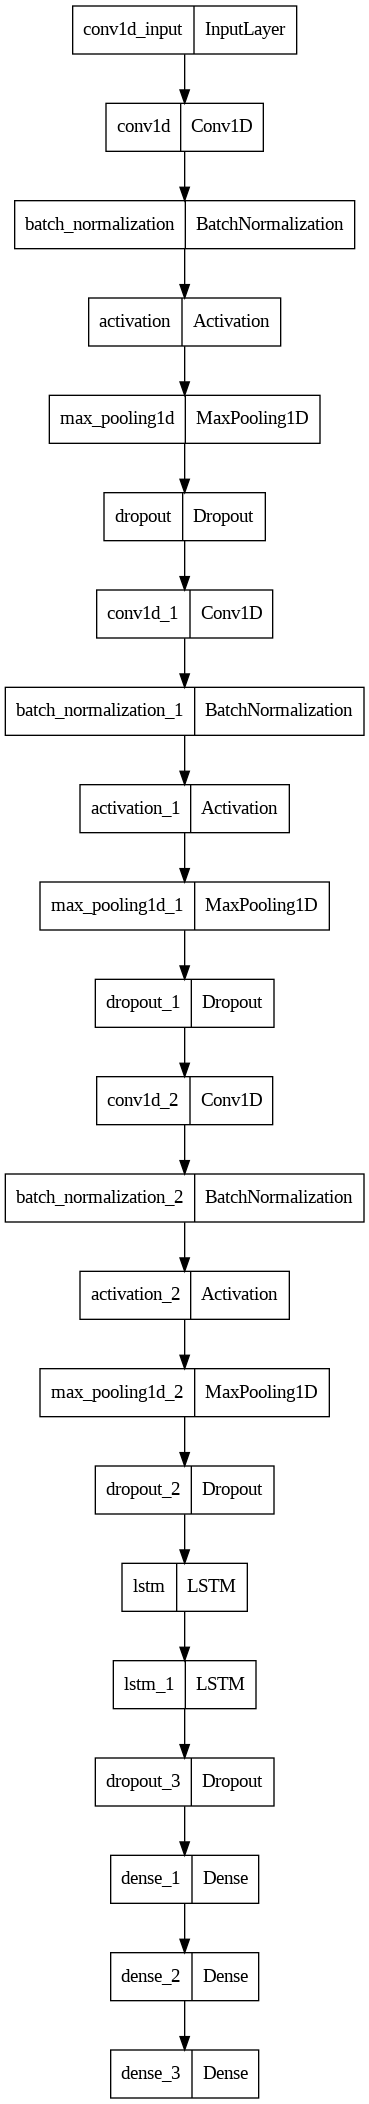

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, Dropout, concatenate, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers

sequence_length = X_train.shape[1] # 1000
input_dim = X_train.shape[2] # 12
num_classes = y_train.shape[1] # 6

model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv1D(32, 3, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv1D(16, 2, activation='relu', input_shape=(sequence_length, input_dim)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(LSTM(32, input_shape=(sequence_length, input_dim), return_sequences=True))

model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))

model2.add(Dense(num_classes, activation='softmax'))


model2.summary()
tf.keras.utils.plot_model(model2)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model with a learning rate of 0.01
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy', 'Precision', 'Recall'])

# Define the callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.0001)

# Train the model with validation
model2.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_valid, y_valid)
                    ,callbacks=[early_stop, reduce_lr])

Epoch 1/100
545/545 [==============================] - 21s 24ms/step - loss: 0.4023 - accuracy: 0.5349 - binary_accuracy: 0.8186 - precision: 0.7401 - recall: 0.2441 - val_loss: 0.3507 - val_accuracy: 0.5735 - val_binary_accuracy: 0.8326 - val_precision: 0.7578 - val_recall: 0.3280 - lr: 0.0010
Epoch 2/100
545/545 [==============================] - 12s 21ms/step - loss: 0.3488 - accuracy: 0.6005 - binary_accuracy: 0.8421 - precision: 0.7511 - recall: 0.3997 - val_loss: 0.3375 - val_accuracy: 0.6180 - val_binary_accuracy: 0.8526 - val_precision: 0.7360 - val_recall: 0.4927 - lr: 0.0010
Epoch 3/100
545/545 [==============================] - 11s 20ms/step - loss: 0.3248 - accuracy: 0.6437 - binary_accuracy: 0.8595 - precision: 0.7676 - recall: 0.4991 - val_loss: 0.3327 - val_accuracy: 0.6202 - val_binary_accuracy: 0.8559 - val_precision: 0.7260 - val_recall: 0.5321 - lr: 0.0010
Epoch 4/100
545/545 [==============================] - 12s 21ms/step - loss: 0.3083 - accuracy: 0.6682 - binary_

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = model2.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test binary accuracy:', test_binary_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

F1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print('F1_score:', F1_score)

69/69 [==============================] - 1s 10ms/step - loss: 0.2778 - accuracy: 0.7011 - binary_accuracy: 0.8779 - precision: 0.8040 - recall: 0.5706
Test loss: 0.2777663767337799
Test accuracy: 0.7010918855667114
Test binary accuracy: 0.8779193162918091
Test precision: 0.8039801120758057
Test recall: 0.5706214904785156
F1_score: 0.6674927906606317


69/69 [==============================] - 1s 7ms/step


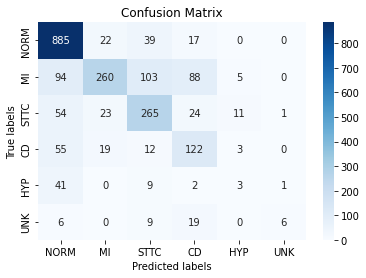

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model2.predict(X_test)
y_pred_arg = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_arg)

# Define the class labels
labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

After training the models, it is evident that the raw ECG signals perform better. Both models using raw ECG signals have higher accuracy, F1 score, and better accuracy on each diagnosis.

The model with two branches has slightly higher accuracy and F1 score than the sequential model. However, the sequential model has fewer false positives on MI. Both models perform poorly on HYP, producing many false positives because it tends to confuse it with NORM. The branched model has relatively high accuracy on the UNK diagnosis, but this may be due to many UNK diagnoses having pacemakers in their metadata. 

The dataset suffers from a significant class imbalance issue, which negatively affects the model's performance on the less common diagnoses. One potential improvement that could have been made to the model is to apply cost-sensitive learning, whereby assigning a higher cost to misclassification of the minority class can help the model give more importance to the minority class samples during training. This can help mitigate the effects of class imbalance and improve the overall performance of the model.

Predicting onset of an event

In [ ]:
model2.save('my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model('my_model.h5')

To predict the onset of a diagnosis in an ECG signal, I will be using the sliding window approach. The sliding window technique splits the ECG signal into smaller parts and evaluates each part using a trained model. I will be using a model that takes two input vectors [X, Y] because I encountered difficulties trying to incorporate the metadata vector Z into the sliding window approach.

In [ ]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

window_size = 400 #1000
stride = 200 #500

# Number of ECG signals to use
num_signals = len(X_test) // 20

# An empty array that stores the predictions
predictions = np.zeros((num_signals, y_train.shape[1]))

labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP', 'UNK']

# Iteration over each ECG signals
for i in range(num_signals): #range(5):
    signal = X_test[i]
    print('\n')
    # Sliding window over a ECG signal
    for j in range(0, len(signal) - window_size + 1, stride):
        window = signal[j:j+window_size]
    
    
        # Prediction beign made using the trained model
        prediction = model2.predict(window.reshape(1, window.shape[0], window.shape[1]))

        print("prediction: ", prediction)
        for j in range(6):
          if prediction[0][j] > 0.5:
            print(f"Diagnosis {labels[j]} for ecg signal: {i}")
            predictions[i][j] += 1;




1/1 [==============================] - 0s 23ms/step
prediction:  [[9.9547476e-01 1.2015902e-03 4.9587345e-04 2.4999981e-03 2.5267559e-04
  7.5167460e-05]]
Diagnosis NORM for ecg signal: 0
1/1 [==============================] - 0s 21ms/step
prediction:  [[9.9173778e-01 2.3865416e-03 1.0348414e-03 4.0920656e-03 5.7234347e-04
  1.7642313e-04]]
Diagnosis NORM for ecg signal: 0
1/1 [==============================] - 0s 22ms/step
prediction:  [[9.6578228e-01 1.1282656e-02 8.8172955e-03 1.0982148e-02 2.2688245e-03
  8.6683064e-04]]
Diagnosis NORM for ecg signal: 0
1/1 [==============================] - 0s 22ms/step
prediction:  [[9.9307030e-01 1.7120213e-03 1.0904487e-03 3.4436157e-03 5.2504666e-04
  1.5850854e-04]]
Diagnosis NORM for ecg signal: 0


1/1 [==============================] - 0s 21ms/step
prediction:  [[9.1988301e-01 2.4258284e-02 5.7896296e-03 4.6682701e-02 2.5580358e-03
  8.2838978e-04]]
Diagnosis NORM for ecg signal: 1
1/1 [==============================] - 0s 20ms/step
pred

I haven't been able to verify the accuracy of these predictions using the sliding window method, as I'm not sure how to go about it. Therefore, I'm uncertain about the performance of the code and whether the sliding window is the optimal approach. Nonetheless, I selected this method as it seemed the most relevant option available to me.

Upon reviewing my code, I realized that I could have utilized more of the higher frequencies in my wavelet transformation. This could have provided valuable information for diagnosing some of the ECG signals, and potentially led to improved accuracy compared to using raw ECG signals alone.